In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import copy
import numpy as np
from numpy.random import *
from os import listdir as ld
from os.path import join as pj
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import visdom
from PIL import Image

# IO
from IO.utils import refine_result_by_ovthresh
from IO.loader import load_path, load_images
from IO.build_ds import build_classification_ds_from_result
# utils
from utils.crop import crop_adjusted_std, crop_adjusted_std_resize
# Dataset
from dataset.detection.dataset import insects_dataset_from_voc_style_txt, collate_fn
# det model
from model.refinedet.refinedet import RefineDet
# cls model
from model.resnet.resnet import ResNet
from model.resnet.predict import test_classification
# Predict
from model.refinedet.utils.predict import test_prediction
# Evaluate
from evaluation.detection.evaluate import Voc_Evaluater, visualize_mean_index
from evaluation.det2cls.visualize import vis_detections

# Test Config

In [3]:
class args:
    # paths
    data_root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
    test_image_root = "/home/tanida/workspace/Insect_Phenology_Detector/data/test_refined_images"
    test_target_root = "/home/tanida/workspace/Insect_Phenology_Detector/data/test_detection_data/target_with_other"
    det_model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/detection/RefineDet", "crop_b2_2_4_8_16_32_im512")
    cls_model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/classification/ResNet101", "resnet50_b20_r45_lr1e-5_crossvalid_other")
    figure_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/result/det2cls", "refinedet_resnet_plus_other")
    save_img_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/figure/det2cls", "refinedet_resnet_plus_other")
    test_anno_folders = ["annotations_4"]
    # det model config
    input_size = 512 # choices=[320, 512, 1024]
    crop_num = (5, 5)
    tcb_layer_num = 5
    use_extra_layer = False
    det_activation_function = "ReLU"
    use_GN_WS = False
    # cls model config
    cls_model_name = "resnet50"
    cls_activation_function = "ReLU"
    decoder = None
    # test config
    det_divide_flag = False
    cls_divide_flag = True

In [4]:
# class label
if args.det_divide_flag is True:
    args.det_labels = ['Aquatic_insects', 'Other_insects']
else:
    args.det_labels = ['insects']

if args.cls_divide_flag is True:
    args.cls_labels = ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                       'Lepidoptera', 'Plecoptera', 'Trichoptera', 'Other']
else:
    args.cls_labels = ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                       'Lepidoptera', 'Plecoptera', 'Trichoptera']

# Set cuda

In [5]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# Detection Model

In [6]:
det_model = RefineDet(args.input_size, len(args.det_labels)+1, args.tcb_layer_num, activation_function=args.det_activation_function, use_extra_layer=args.use_extra_layer, use_GN_WS=args.use_GN_WS)
load_name = pj(args.det_model_root, 'RefineDet{}_{}.pth'.format(args.input_size, "final"))
det_model.load_state_dict(torch.load(load_name))

activation_function = ReLU
init_function = xavier_uniform_
Initializing weights ...


<All keys matched successfully>

# Classification Model

In [7]:
cls_model = ResNet(args.cls_model_name, len(args.cls_labels), activation_function=args.cls_activation_function, decoder=args.decoder).cuda()
load_name = pj(args.cls_model_root, "final.pth")
cls_model.load_state_dict(torch.load(load_name))

activation_function = ReLU


<All keys matched successfully>

### Make data

In [8]:
print('Loading dataset for test ...')
test_dataset = insects_dataset_from_voc_style_txt(args.test_image_root, args.input_size, args.crop_num, "RefineDet", training=False)
test_data_loader = data.DataLoader(test_dataset, 1, num_workers=1, shuffle=False, collate_fn=collate_fn)
print('Loading images ...')
anno_paths, image_paths = load_path(args.data_root, "refined_images", args.test_anno_folders)
images = load_images(image_paths)

Loading dataset for test ...
Loading images ...


# --- result analysis ---

In [9]:
if os.path.exists(args.figure_root) is False:
    os.makedirs(args.figure_root)

In [10]:
def get_det_result(det_model, data_loader, crop_num, num_classes, nms_thresh=0.3, ovthresh=0.3):
    det_result = test_prediction(det_model, data_loader, crop_num, num_classes, nms_thresh)
    det_result = refine_result_by_ovthresh(det_result, ovthresh)
    return det_result

In [11]:
det_result = get_det_result(det_model, test_data_loader, args.crop_num, len(args.det_labels)+1)

  0%|          | 0/10 [00:00<?, ?it/s]

detecting ... : 20180615-0348


 10%|█         | 1/10 [00:02<00:19,  2.18s/it]

detecting ... : 20180614-2208


 20%|██        | 2/10 [00:03<00:15,  1.92s/it]

detecting ... : 20180614-2048


 30%|███       | 3/10 [00:04<00:12,  1.73s/it]

detecting ... : 20180615-0118


 40%|████      | 4/10 [00:06<00:09,  1.59s/it]

detecting ... : 20180615-0208


 50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

detecting ... : 20180614-2218


 60%|██████    | 6/10 [00:08<00:05,  1.42s/it]

detecting ... : 20180615-0238


 70%|███████   | 7/10 [00:09<00:04,  1.37s/it]

detecting ... : 20180614-2248


 80%|████████  | 8/10 [00:11<00:02,  1.33s/it]

detecting ... : 20180615-0440


 90%|█████████ | 9/10 [00:12<00:01,  1.31s/it]

detecting ... : 20180710-2248


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


In [12]:
insect_dataset = build_classification_ds_from_result(images, det_result)

  0%|          | 0/97 [00:00<?, ?it/s]

creating images: 20180615-0348


  0%|          | 0/79 [00:00<?, ?it/s]

creating images: 20180614-2208


  0%|          | 0/79 [00:00<?, ?it/s]

creating images: 20180614-2048


  0%|          | 0/47 [00:00<?, ?it/s]

creating images: 20180615-0118


  0%|          | 0/44 [00:00<?, ?it/s]

creating images: 20180615-0208


  0%|          | 0/68 [00:00<?, ?it/s]

creating images: 20180614-2218


  0%|          | 0/46 [00:00<?, ?it/s]

creating images: 20180615-0238


  0%|          | 0/60 [00:00<?, ?it/s]

creating images: 20180614-2248


  0%|          | 0/60 [00:00<?, ?it/s]

creating images: 20180615-0440


  0%|          | 0/57 [00:00<?, ?it/s]

creating images: 20180710-2248


100%|██████████| 57/57 [00:20<00:00,  2.76it/s]


In [13]:
def get_det2cls_result(cls_model, insect_dataset, det_result, det_divide_flag=False):
    det2cls_result = {}
    for image_id, imgs in insect_dataset.items():
        print("classify images: {}".format(image_id))
        det2cls_result_per_image = copy.copy(det_result[image_id])
        if det_divide_flag:
            det2cls_result_per_image.update({len(args.cls_labels)+1: det_result[image_id][1]})
        
        imgs = torch.from_numpy(imgs).cuda()
        lbls = test_classification(cls_model, imgs, bs=20)
        coords = det_result[image_id][0]
        for lbl in range(len(args.cls_labels)):
            lbl_filter = lbls == lbl
            filtered_coords = coords[lbl_filter]
            det2cls_result_per_image.update({lbl: filtered_coords})
        det2cls_result.update({image_id: det2cls_result_per_image})
    return det2cls_result

In [14]:
det2cls_result = get_det2cls_result(cls_model, insect_dataset, det_result, det_divide_flag=False)

classify images: 20180615-0348
classify images: 20180614-2208
classify images: 20180614-2048
classify images: 20180615-0118
classify images: 20180615-0208
classify images: 20180614-2218
classify images: 20180615-0238
classify images: 20180614-2248
classify images: 20180615-0440
classify images: 20180710-2248


initialize evaluater ...
setting result ...


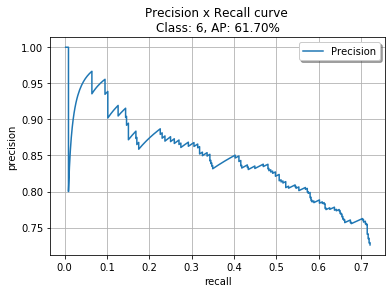

In [15]:
evaluater = Voc_Evaluater(args.test_image_root, args.test_target_root, args.figure_root)
evaluater.set_result(det2cls_result)
eval_metrics = evaluater.get_eval_metrics()

In [16]:
visualize_mean_index(eval_metrics)

--- evaluation index for Other ---
AP = 0.6170360148568697
precision = 0.7260579064587973
recall = 0.7212389380530974
--- evaluation index for Target ---
mAP = 0.6348949081548121
mean_precision = 0.7113197340018326
mean_recall = 0.7734651101586585


# --- Output image with result ---

In [17]:
if os.path.exists(args.save_img_root) is False:
    os.makedirs(args.save_img_root)

In [18]:
def get_imagenames_from_anno_paths(anno_paths):
    imagenames = [anno_path.split('/')[-1] for anno_path in anno_paths]
    if '.ipynb_checkpoints' in imagenames:
        imagenames.remove('.ipynb_checkpoints')
    imagenames = [imagename.split('.')[0] for imagename in imagenames]
    return imagenames

In [19]:
imagenames = get_imagenames_from_anno_paths(anno_paths)
colors = ["white", "red", "lime", "blue", "yellow", "fuchsia", "aqua", "gray", "maroon", "green", "navy", "olive", "purple", "teal"]
insect_names = ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                'Lepidoptera', 'Plecoptera', 'Trichoptera', 'Other']

In [20]:
def read_ground_truth(test_target_path, insect_names, height, width):
    gt_coord = {}
    for lbl in range(len(insect_names)):
        gt_coord.update({lbl: []})

    with open(test_target_path, mode="r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.split('\n')[0]
            elements = line.split(' ')
            target_lbl = int(elements[4])
            x1 = float(elements[0]) * width
            x2 = float(elements[2]) * width
            y1 = float(elements[1]) * height
            y2 = float(elements[3]) * height
            coord = [x1, y1, x2, y2]
            gt_coord[target_lbl].append(coord)
    
    for lbl in range(len(insect_names)):
        gt_coord[lbl] = np.asarray(gt_coord[lbl])
    
    return gt_coord

In [21]:
def output_img_with_result(det2cls_result, test_image_root, test_target_root, imagenames, insect_names, save_img_root):
    for i in range(len(imagenames)):
        print("output image: {}".format(imagenames[i]+".png"))
        img = np.asarray(Image.open(pj(test_image_root, imagenames[i]+".png")))
        height, width, _ = img.shape
        gt_coord = read_ground_truth(pj(test_target_root, imagenames[i]+".txt"), insect_names, height, width)
        coord_per_image = copy.copy(det2cls_result[imagenames[i]])
        for lbl in range(len(insect_names)):
            img = vis_detections(img, coord_per_image[lbl], class_name=insect_names[lbl], color_name=colors[lbl])
            img = vis_detections(img, gt_coord[lbl], class_name=insect_names[lbl], color_name=colors[lbl])
        
        img = Image.fromarray(img)
        img.save(pj(save_img_root, imagenames[i]+".png"))

In [22]:
output_img_with_result(det2cls_result, args.test_image_root, args.test_target_root, imagenames, insect_names, args.save_img_root)

output image: 20180615-0440.png
output image: 20180615-0208.png
output image: 20180710-2248.png
output image: 20180614-2248.png
output image: 20180615-0238.png
output image: 20180614-2208.png
output image: 20180614-2048.png
output image: 20180614-2218.png
output image: 20180615-0348.png
output image: 20180615-0118.png
